In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse as ph   # библиотека для подключения к clickhouse
from scipy import stats

sns.set(style='whitegrid')

In [141]:
# библиотеки для подключения к api Яндекс.Диска
from urllib.parse import urlencode
import requests
# Чтобы загрузить данные в Jupyter Notebook, используем api Яндекс.Диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

# A/B–тестирование
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы осталась базовая механика.

In [142]:
# в переменную public_key сохраним ссылку на Яндекс.Диск, где находятся данные для скачивания
public_key = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ' 

final_url = base_url + urlencode(dict(public_key=public_key)) 
active_studs = pd.read_csv(requests.get(final_url).json()['href'])

active_studs - информация о пользователях, которые зашли на платформу в дни проведения эксперимента

In [143]:
active_studs.head(2)

,student_id
0,581585
1,5723133


In [144]:
# пропусков нет, 8341 строка
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [145]:
active_studs.student_id.nunique()

8341

In [146]:
# в переменную public_key сохраним ссылку на Яндекс.Диск, где находятся данные для скачивания
public_key = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA' 

final_url = base_url + urlencode(dict(public_key=public_key)) 
checks = pd.read_csv(requests.get(final_url).json()['href'], sep=';')

checks - информация об оплатах пользователей в дни проведения эксперимента

In [147]:
checks.head(2)

,student_id,rev
0,1627,990.0
1,3185,690.0


In [148]:
# пропусков нет, 541 строка
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [149]:
checks.nunique()

student_id    541
rev            39
dtype: int64

In [150]:
# в переменную public_key сохраним ссылку на Яндекс.Диск, где находятся данные для скачивания
public_key = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ' 

final_url = base_url + urlencode(dict(public_key=public_key)) 
groups = pd.read_csv(requests.get(final_url).json()['href'], sep=';')

groups - информация о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

In [151]:
groups.head(2)

,id,grp
0,1489,B
1,1627,A


In [152]:
# пропусков нет, 74484строк
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [153]:
groups.id.nunique()

74484

In [154]:
# добавим инфомацию о группе, в которую попал студент, используем merge и inner join
# чтобы столбцы не дублировались, удалим один из них при помощи drop
experiment = pd.merge(active_studs, groups, left_on='student_id', right_on='id').drop('id', axis=1)

In [155]:
# есть пользователи (13), которым не нашлось совпадений и потому отсеились при объединении таблиц
experiment.shape

(8328, 2)

In [156]:
# добавим информацию об оплате, используем merge и left join, пропуски заполним нулями
experiment = pd.merge(experiment, checks, how='left', on='student_id').fillna(0)

In [157]:
# посмотрим на распределение по группам, в группе А - 1538 пользователей, в В - 6803
experiment.grp.value_counts()

B    6793
A    1535
Name: grp, dtype: int64

In [158]:
# процентное распределение по группам
experiment.grp.value_counts(normalize=True)

B    0.815682
A    0.184318
Name: grp, dtype: float64

Выборка несбалансированна, в контрольной группе 18,4% пользователей, а в тестовой - 81,6%

Если сделать новую механику оплаты, то повысится конверсия в покупку, потому что это упращает процедуру приобретения. И это будет влиять на то, что больше пользователей приобретут товар. Поэтому основной метрикой для проверки гипотезы будет CR (конверсия в покупку). С другой стороны, можно повысить конверсию, а доход упадет. Бизнесу важно зарабатывать, и главная цель экспериментов - это повысить прибыль. Поэтому дополнительно можно будет исследовать метрику ARPU(средний чек на всех пользователей) и ARPPU(средний чек платящих пользователей). 

Критерий для проверки гипотезы: 
Для проверки гипотезы будем использовать T-test. Его можно использовать и при ненормальном распределении, если объем выборок достаточно большой. Тест Мана-Уитни нам не подойдет, так как его сложно интерпретировать (он не сравнивает средние) и плохо работает на повторяющихся данных. Бутстрап очень ресурсозатратный, и его лучше применять, только если нет других вариантов.

In [159]:
# делаем колонку, где купивший что-то пользователь будет 1, не купивший - 0
experiment['purchase'] = experiment.rev.apply(lambda x: 0 if x == 0 else 1)

In [160]:
# группируем по группам, и подсчитываем кол-во пользоватлелей, принесенный ими доход, ARPU (средний платеж по группам)
metrics = experiment.groupby('grp', as_index=False).agg(quantity=('student_id', 'count'),
                                                        money=('rev', 'sum'),
                                                        ARPU=('rev', 'mean'),
                                                        CR=('purchase', 'mean'),
                                                        buyers=('purchase', 'sum'))

In [161]:
# посчитаем ARPPU, разделим доход от пользователей на кол-во купивших пользователей
metrics['ARPPU'] = metrics.money / metrics.buyers

In [162]:
metrics

,grp,quantity,money,ARPU,CR,buyers,ARPPU
0,A,1535,72820.0000,47.439739,0.050814,78,933.589744
1,B,6793,393074.0035,57.864567,0.046077,313,1255.827487


Сравним выборки на основе конверсии в покупку

In [163]:
# в переменные запишем значения колонки purchase только из группы А и В
# так как среднее по этой колонке - это CR, то так и проверим различия по этой метрике
control = experiment.query('grp == "A"').purchase
treatment = experiment.query('grp == "B"').purchase

In [164]:
stats.ttest_ind(control, treatment)

Ttest_indResult(statistic=0.7924122313723829, pvalue=0.42814292677134336)

Вывод: p_value больше 0,05, следовательно, нулевую гипотезу о равенстве средних отклонить не можем. Значит, конверсии у контрольной и тестовой группы не имеют статистически значимых различий.

Сравним две выборки по метрике ARPU

In [165]:
# в переменные запишем значения колонки rev только из группы А и В
control = experiment.query('grp == "A"').rev
treatment = experiment.query('grp == "B"').rev

In [166]:
stats.ttest_ind(control, treatment)

Ttest_indResult(statistic=-1.193059426205367, pvalue=0.23288009643249283)

Вывод: p_value больше 0,05, таким образом, отклонить нулевую гипотезу не можем. Значит, группы не имеют статистически значимых различий.

Сравним две выборки по метрике ARPPU

In [167]:
# в переменные запишем значения колонки rev только из группы А и В
control = experiment.query('grp == "A" and rev > 0').rev
treatment = experiment.query('grp == "B" and rev > 0').rev

In [168]:
stats.ttest_ind(control, treatment)

Ttest_indResult(statistic=-3.1114389810411063, pvalue=0.001999178025210522)

Вывод: p_value сильно ниже 0,05, это означает, что присутствует различие в средних. Таким образом, средний чек платящего полязователя по группам ститистически значимо различаются.

Посмотри, где именно появилась разница

In [169]:
# оставим только совершенные покупки
only_purchase = experiment.query('rev > 0')

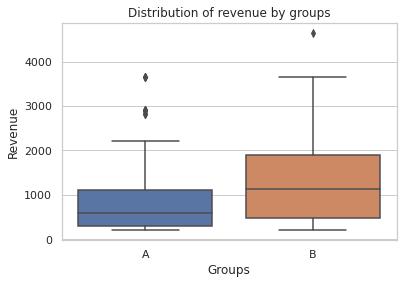

In [170]:
# boxplot только с дохода
sns.boxplot(data=only_purchase, x='grp', y='rev')
plt.title('Distribution of revenue by groups')
plt.xlabel('Groups')
plt.ylabel('Revenue');

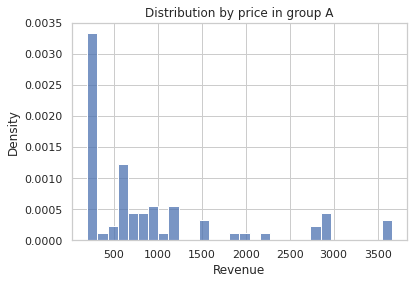

In [171]:
# гистограмма распределения по группе А
sns.histplot(only_purchase[only_purchase.grp == 'A'].rev, kde=False, stat='density', bins=30)
plt.title('Distribution by price in group A')
plt.xlabel('Revenue');

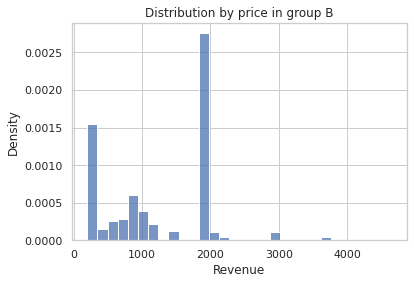

In [172]:
# гистограмма распределения по группе В
sns.histplot(only_purchase[only_purchase.grp == 'B'].rev, kde=False, stat='density', bins=30)
plt.title('Distribution by price in group B')
plt.xlabel('Revenue');

In [173]:
# посмотрим процентное распределение по сумме в группе А
only_purchase[only_purchase.grp == 'A'].rev.value_counts(normalize=True).head()

290.0    0.320513
580.0    0.076923
990.0    0.064103
590.0    0.064103
199.0    0.064103
Name: rev, dtype: float64

In [174]:
# посмотрим процентное распределение по сумме в группе В
only_purchase[only_purchase.grp == 'B'].rev.value_counts(normalize=True).head()

1900.0000    0.293930
290.0000     0.143770
1900.0001    0.111821
199.0000     0.086262
840.0000     0.067093
Name: rev, dtype: float64

Можно заметить, что существенное отличие в группе В в отличии от А по сумме 1900. Примерно 40% пользователей совершили покупку на эту сумму. И так же в группе В присутствует странное значение - 1900.0001. Что может говорить о том, что новая механика оплаты работает некорректно либо неправильная обработка данных. 

# Вывод
Эксперимент проводился на несбалансированной выборке, примерно 81,6% пользователей в тестовой группе и 18,4% в контрольной. Стоит заметить, что делать так не принято и не правильно, поскольку тестовая выборка обычно меньше контрольной. Это может быть связано с плохой работой сплит системы или неправильным проведением эксперимента.

Основной метрикой для проверки гипотезы была выбрана конверсия в покупку, потому что новая механика оплаты должна упрощать процесс приобретения и пользователи должны чаще совершать целевое действие. Статистически значимых различий между группами выявлено не было. С другой стороны, наблюдалось повышение метрики ARPU(статистически незначимо) и ARPPU(статистически значимо). Исследовав, было обнаружено большое кол-во пользователей, которые совершили покупку на 1900, главное отличие от контрольной группы. Необходимо выяснить причины такого отклонения. Может, паралельно проводился еще один эксперимент либо какая-нибудь акция на товар по этой цене. Это могло повлиять на ход этого эксперимента и опять поставить под сомнение правильность его проведения.

Таким образом, новую механику оплаты запускать на всех пользователей не стоит. Так как конверсия статистически значимо не изменилась. 

# Задание 2. SQL

Подключение к clickhouse

In [175]:
# чтение файла, где записаны данные для подключения к clickhouse: хост, имя пользователя и пароль
# все записывается в соответствующие переменные
with open('connect_to_sql', 'r') as f:
    text = f.read().split('\n')
    host = text[0]
    user = text[1]
    password = text[2]

In [176]:
# создаем переменную с данными для подключения
connection = dict(database='default',
                 host=host,
                 user=user,
                 password=password)

Используются таблицы: 
- studs - разделение пользователей на группы, участвующих в эксперименте (control, pilot). 600 строк и 600 уникальных пользователей;
- peas - данные о результатах решения задач пользователями (правильно или нет решена задача и по какому предмету). 13245 строк и 308 уникальных пользователей;
- final_project_check - данные об оплате предметов пользователями. Оплата нужна, чтобы решать больше 30 задач в день. 61 строка и 47 уникальных пользователей.

# Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

Напишем запрос и посчитаем количество усердных студентов. Под усердным студентом мы понимаем студента, который правильно решил 20 и более задач.

In [177]:
# посчитаем количество строк из подзапроса
# подзапрос: сгруппируем студентов и посчитаем кол-во правильно сделаных задач(так как там правильно решенная - это 1, 
# то просто суммируем)
# фильтруем через HAVING, отбираем только тех студентов, которые решили 20 и более задач

query = """
SELECT 
    COUNT(*)
FROM
(SELECT 
    st_id,
    SUM(correct) AS quantity_correct
FROM default.peas
GROUP BY st_id
HAVING quantity_correct >= 20)
"""

diligent_students = ph.read_clickhouse(query, connection=connection)

In [178]:
print(f'{diligent_students.iloc[0, 0]} усердных студентов учатся на курсе, которые решили 20 и более задач.')

136 усердных студентов учатся на курсе, которые решили 20 и более задач.


# Образовательная платформа проводит эксперимент, где тестируется новый экран оплаты
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
- ARPU - средний платеж на всех зарегистрированных игроков;
- ARPAU - средний платеж на всех активных пользователей;
- CR в покупку - отношение числа пользователей, которые совершили покупку к общему числу пользователей;
- СR активного пользователя в покупку - отношение числа активных пользователей, которые совершили покупку к общему числу активных пользователей;
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике - отношение числа активных пользователей по математике, которые совершили покупку к общему числу активных пользователей по математике.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

### Найдем необходимые нам метрики
используем left join, чтобы не потерять данные из таблицы studs

In [179]:
query = """
SELECT 
    test_grp,
    uniqExact(studs.st_id) AS uniq_user,
    uniqIf(studs.st_id, total_peas > 10) AS active_users,
    uniqIf(studs.st_id, money > 0) AS buyers,
    sum(money) AS users_money,
    sum(money)/uniqExact(studs.st_id) AS ARPU,
    sumIf(money, total_peas > 10)/uniqIf(studs.st_id, total_peas > 10) AS ARPAU,
    uniqIf(studs.st_id, money > 0)/uniqExact(studs.st_id) AS CR,
    uniqIf(studs.st_id, money > 0 AND total_peas > 10)/uniqIf(studs.st_id, total_peas > 10) AS CR_active,
    uniqIf(studs.st_id, money > 0 AND peas_by_math > 1 AND subject = 'Math')/uniqIf(studs.st_id, peas_by_math > 1) AS CR_math

FROM
  default.studs AS a
  LEFT JOIN (
            SELECT
              st_id,
              subject,
              money
            FROM
              default.final_project_check
          ) AS b
  ON a.st_id = b.st_id
  LEFT JOIN (
            SELECT
              st_id,
              SUM(correct) AS total_peas,
              SUMIf(correct, subject = 'Math') AS peas_by_math
            FROM
              default.peas
            GROUP BY
              st_id
          ) AS c 
  ON a.st_id = c.st_id
GROUP BY test_grp
"""
payment_test = ph.read_clickhouse(query, connection=connection)

In [180]:
payment_test

,test_grp,uniq_user,active_user,buyers,active_buyers,money,ARPU,ARPAU,CR,CR_active_buyers,CR_math
0,control,305,127,15,14,1385000,4540.98,10393.70,0.049180,0.110236,0.061224
1,pilot,295,96,32,25,3395000,11508.47,29739.58,0.108475,0.260417,0.095238


In [182]:
# рассчитаем различия между метриками в процентах и запишем в переменную
money_diff = round(100 - payment_test.loc[0, 'money'] / payment_test.loc[1, 'money'] * 100, 2)
ARPU_diff = round(100 - payment_test.loc[0, 'ARPU'] / payment_test.loc[1, 'ARPU'] * 100, 2)
ARPAU_diff = round(100 - payment_test.loc[0, 'ARPAU'] / payment_test.loc[1, 'ARPAU'] * 100, 2)
CR_diff = round(100 - payment_test.loc[0, 'CR'] / payment_test.loc[1, 'CR'] * 100, 2)
CR_active_buyers_diff = round(100 - payment_test.loc[0, 'CR_active_buyers'] / 
                              payment_test.loc[1, 'CR_active_buyers'] * 100, 2)
CR_math_diff = round(100 - payment_test.loc[0, 'CR_math'] / payment_test.loc[1, 'CR_math'] * 100, 2)

In [183]:
print(f"Доход, принесенный пользователями в группе pilot выше на {money_diff}%, чем в группе control")
print(f"Значение метрики ARPU в группе pilot выше на {ARPU_diff}%, чем в группе control")
print(f"Значение метрики ARPAU в группе pilot выше на {ARPAU_diff}%, чем в группе control")
print(f"Значение метрики CR в группе pilot выше на {CR_diff}%, чем в группе control")
print(f"Количество активных пользователей купивших предмет в группе pilot выше \
на {CR_active_buyers_diff}%, чем в группе control")
print(f"Количество активных пользователей по математике купивших этот предмет в группе pilot выше \
на {CR_math_diff}%, чем в группе control")

Доход, принесенный пользователями в группе pilot выше на 59.2%, чем в группе control
Значение метрики ARPU в группе pilot выше на 60.54%, чем в группе control
Значение метрики ARPAU в группе pilot выше на 65.05%, чем в группе control
Значение метрики CR в группе pilot выше на 54.66%, чем в группе control
Количество активных пользователей купивших предмет в группе pilot выше на 57.67%, чем в группе control
Количество активных пользователей по математике купивших этот предмет в группе pilot выше на 35.71%, чем в группе control


В итоге можно сделать промежуточный вывод: мы можем наблюдать положительную динамику в связи с внедрением новой системы оплаты. Все исследуемые метрики показывают улучшения более чем в полтора раза больше у тестовой по сравнению с контрольной группой. Так же, в контрольной группе активных пользователей (127) больше, чеи в тестовой (96). Что может говорить о том, что пользователи с новым экраном оплаты быстрее принимают решение о покупке.

Но делать окончательные выводы еще рано, поскольку эксперимент охватил только примерно сутки (данные собраны с 2021-10-30 13:00 по 2021-10-31 17:30) и не учитывается поведение аудитории в остальные дни недели. Возможно, изменение имеет отложенный эффект: в понедельник пользователь попал в тестовую группу, а в пятницу принял решение. Так как у каждой метрики есть "окно" — пользователь не сразу принимает решение о том, чтобы совершить желанное действие для продукта. Обычно это связано с ценой продукта. Чем выше цена, тем больше времени требуется пользователю для принятия решения о покупке. Поэтому, чтобы сделать какие-то выводы, необходимо продлить эксперимент по времени и собрать больше данных. Если тенденция сохранится и пользователи будут быстрее принимать решение о покупке в тестовой группе, то можно будет считать эксперимент положительным.

# Python
- Реализовать функцию, которая будет автоматически подгружать информацию из дополнительного файла  и на основании дополнительных параметров пересчитывать метрики.
- Реализовать функцию, которая будет строить графики по получаемым метрикам.

In [184]:
# в переменную public_key сохраним ссылку на Яндекс.Диск, где находятся данные для скачивания
public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'

In [185]:
def add_information(public_key, active_studs, checks, experiment):
    """функция, которая будет автоматически подгружать информацию из дополнительного файла: 
    скачать, объеденить данные и подсчитать метрики"""
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    groups_add = pd.read_csv(requests.get(final_url).json()['href'])
#   объединяем с active_studs, используем inner join, так останутся только те, совпадают по новой таблице
    add_user = pd.merge(active_studs, groups_add, left_on='student_id', right_on='id').drop('id', axis=1)
#   добавляем информацию о чеках
    add_user = pd.merge(add_user, checks, how='left').fillna(0)
#   делаем колонку, где купивший - 1, не купивший - 0
    add_user['purchase'] = add_user.rev.apply(lambda x: 0 if x == 0 else 1)
#   добавляем в основную таблицу новую информацию
    experiment = pd.concat([experiment, add_user], ignore_index=True)
#   группируем по группам, и подсчитываем кол-во пользоватлелей, принесенный ими доход, ARPU (средний платеж по группам)
    metrics_add = experiment.groupby('grp', as_index=False).agg(quantity=('student_id', 'count'),
                                                                money=('rev', 'sum'),
                                                                ARPU=('rev', 'mean'),
                                                                CR=('purchase', 'mean'),
                                                                buyers=('purchase', 'sum'))
# посчитаем ARPPU, разделим доход от пользователей на кол-во купивших пользователей
    metrics_add['ARPPU'] = metrics_add.money / metrics_add.buyers
    return metrics_add

In [186]:
def vizualization(x):
    """функция, которая строит графики по метрикам: CR, ARPU, ARPPU"""
    # рисуем три барплота подряд
    fig, axes = plt.subplots(3, figsize=(8, 10), sharex=True)
    fig.suptitle('Metrics')
    # CR
    sns.barplot(data=x, x='grp', y='CR', ax=axes[0])
    axes[0].set_title('CR')
    fig.get_axes()[0].set_ylabel('Purchases, %')
    # ARPU
    sns.barplot(data=x, x='grp', y='ARPU', ax=axes[1])
    axes[1].set_title('ARPU')
    fig.get_axes()[1].set_ylabel('Revenue')
    # ARPPU
    sns.barplot(data=x, x='grp', y='ARPPU', ax=axes[2])
    axes[2].set_title('ARPPU')
    fig.get_axes()[2].set_ylabel('Revenue')
    fig.get_axes()[2].set_xlabel('Groups')
    
    # убирем подпись под графиками, кроме последнего
    for ax in fig.get_axes():
        ax.label_outer()

In [187]:
# применим функцию и обновим данные
metrics_add = add_information(public_key, active_studs, checks, experiment)

KeyError: 'href'

In [ ]:
# рисуем графики по обновленным данным
vizualization(metrics_add)

In [ ]:
# таблица метрик без дополнительной информации
metrics

In [ ]:
# таблица метрик с обновленными данными
metrics_add